In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 2 Data Cleaning and Handling Inconsistencies

In [2]:
# Load the dataset
file_path = "/Users/ivy/Desktop/daily_summary_2014_to_2017.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_date             1461 non-null   object 
 1   day of week             1461 non-null   object 
 2   avg fares               1461 non-null   float64
 3   total fares             1461 non-null   float64
 4   tip percentage          1461 non-null   float64
 5   duration                1461 non-null   float64
 6   frequency_of_rides      1461 non-null   int64  
 7   avg trip distance       1461 non-null   float64
 8   tip amount avg          1461 non-null   float64
 9   avg passengers          1461 non-null   float64
 10  sum of passengers       1461 non-null   int64  
 11  avg fare per mile       1461 non-null   float64
 12  Bronx_Pickups           1461 non-null   float64
 13  Brooklyn_Pickups        1461 non-null   float64
 14  EWR_Pickups             1461 non-null   

In [5]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 pickup_date               0
day of week               0
avg fares                 0
total fares               0
tip percentage            0
duration                  0
frequency_of_rides        0
avg trip distance         0
tip amount avg            0
avg passengers            0
sum of passengers         0
avg fare per mile         0
Bronx_Pickups             0
Brooklyn_Pickups          0
EWR_Pickups               0
Manhattan_Pickups         0
Queens_Pickups            0
Staten Island_Pickups     0
Unknown_Pickups           0
Bronx_Dropoffs            0
Brooklyn_Dropoffs         0
EWR_Dropoffs              0
Manhattan_Dropoffs        0
Queens_Dropoffs           0
Staten Island_Dropoffs    0
Unknown_Dropoffs          0
dtype: int64


In [7]:
# Check for duplicate entries
print("Duplicate Entries:", df.duplicated().sum())

Duplicate Entries: 0


In [141]:
# check column type
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['pickup_date', 'day of week'], dtype='object')


In [143]:
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['day of week'] = df['day of week'].astype('category')

<font size="4">    
The dataset comprises 1,461 daily taxi ride summaries spanning from 2014 to 2017, containing 26 attributes that capture essential ride metrics. These include `pickup_date` and `day_of_week` for temporal analysis, as well as numerical attributes such as `avg fares`, `total fares`, `tip percentage`, `duration`, and `avg trip distance`. The dataset also features borough-specific pickup and drop-off counts, providing insights into geographic ride distribution.

Initial data inspection reassuares a well-structured dataset, there is **no missing values or duplicate entries**. For specific column, The average fare per ride is approximately **$12.77**, with **total fares per day** showing substantial variation, likely driven by fluctuating demand patterns. The `tip percentage` has a median of **10.97%**, but its maximum value of **93.53%** suggests possible outliers, indicating some exceptionally high tips. As a consequence, the next step should deal with outliers and leverages before further analysis. The average trip duration is **14.05 minutes**, and the average trip distance is **8.18 miles**, though the maximum recorded distance of **193.88 miles** points to potential anomalies, possibly long-distance or inter-city rides.

From a geographic perspective, borough-level pickup and drop-off data highlight **Manhattan as the central hub** for taxi activity, given its high daily ride counts. Other boroughs such as Brooklyn and Queens also contribute significantly, while **Staten Island records minimal ride activity**, consistent with its lower taxi demand. The number of passengers per trip generally ranges between **1.56 and 1.83**, reinforcing that **most rides are taken by solo passengers or small groups**.
</font>

In [74]:
# Define numerical columns for analysis
numerical_columns = [
    "avg fares", "total fares", "tip percentage", "duration",
    "frequency_of_rides", "avg trip distance", "tip amount avg",
    "avg passengers", "sum of passengers", "avg fare per mile"
]

In [76]:
# Compute skewness for numerical columns
skewness = df[numerical_columns].skew()

# Display skewness values
print(skewness)

avg fares            -0.216675
total fares          -0.076373
tip percentage       -0.387932
duration              0.074062
frequency_of_rides    0.045894
avg trip distance    -0.027640
tip amount avg       -0.305442
avg passengers        0.429120
sum of passengers     0.176732
avg fare per mile    -0.144759
dtype: float64


<font size="4">   
Based on the skewness values, we can see that none of the numerical features are highly skewed. Most values are close to 0, meaning the data is approximately normally distributed. Therefore, there is no need to do log gransformation
</font>

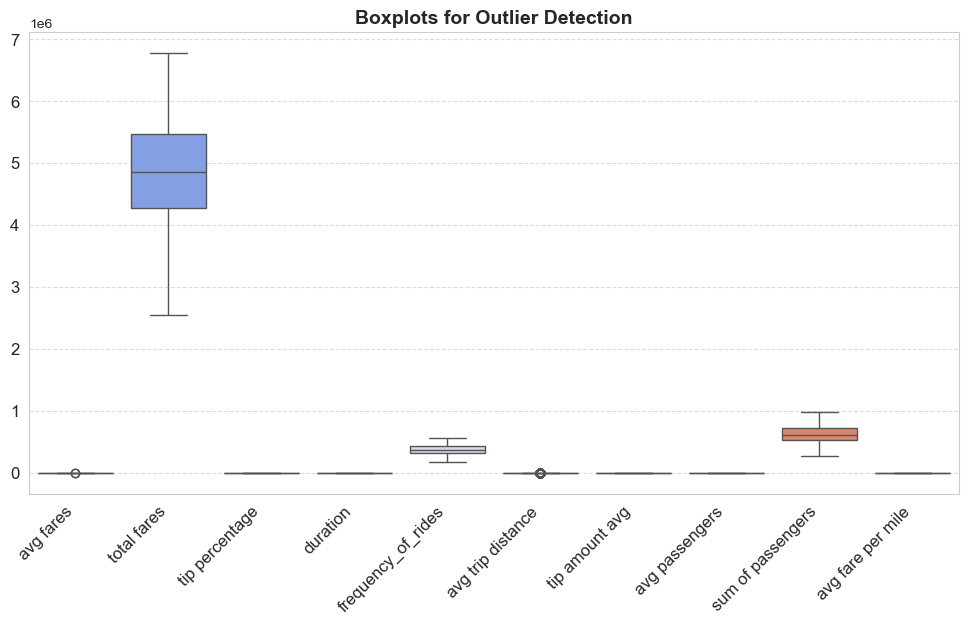

In [80]:
# 1. Boxplots for Outlier Detection (Visual)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.boxplot(data=df[numerical_columns], palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Boxplots for Outlier Detection", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [82]:
# 2. Statistical Outlier Detection (IQR + Z-score)
outliers_detected = {}

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

    z_scores = np.abs(stats.zscore(df[col]))
    z_outliers = df[z_scores > 3].index.tolist()

    combined_outliers = set(iqr_outliers + z_outliers)
    outliers_detected[col] = list(combined_outliers)


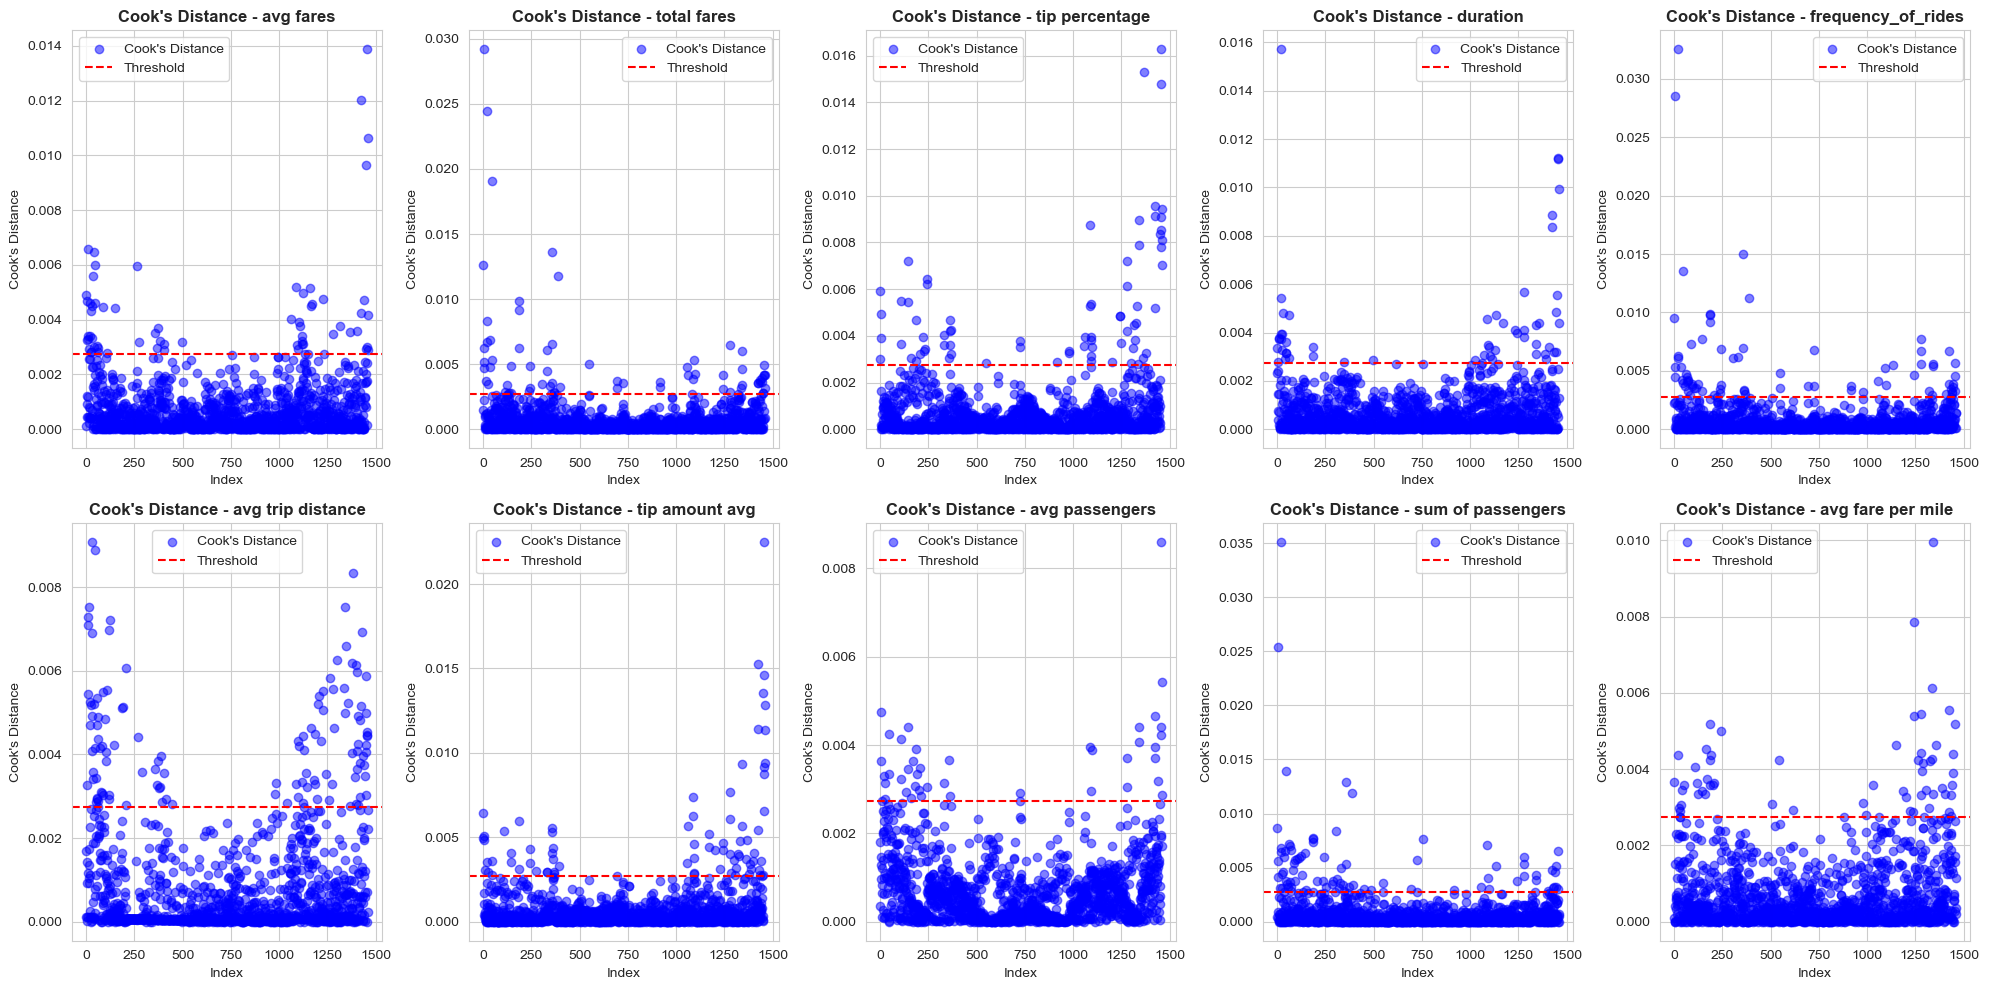

In [86]:
# 3. Detect Leverage Points using Cook’s Distance
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

leverage_detected = {}

for i, col in enumerate(numerical_columns):
    X = sm.add_constant(df.index)  # Using index as an independent variable
    model = sm.OLS(df[col], X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    leverage_indices = np.where(cooks_d > 4 / len(df))[0]  # Cook's threshold
    leverage_detected[col] = list(leverage_indices)

    # Scatter plot for leverage points
    axes[i].scatter(df.index, cooks_d, alpha=0.5, color='blue', label="Cook's Distance")
    axes[i].axhline(4 / len(df), color="r", linestyle="--", label="Threshold")
    axes[i].set_title(f"Cook's Distance - {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Index", fontsize=10)
    axes[i].set_ylabel("Cook's Distance", fontsize=10)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print outliers detected
#print("Outliers detected (IQR & Z-score):", outliers_detected)
#print("Leverage points detected (Cook's Distance):", leverage_detected)


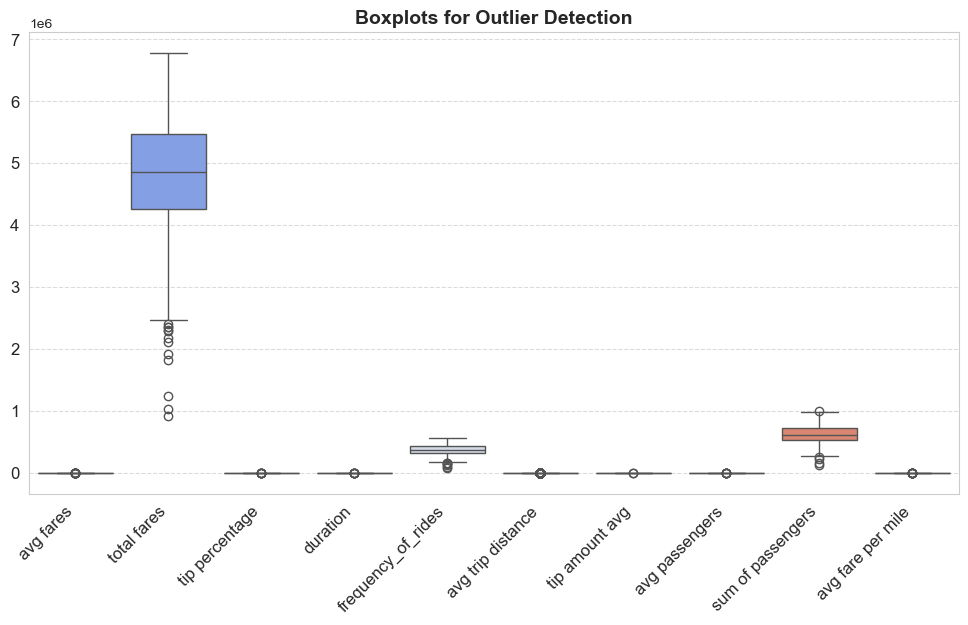

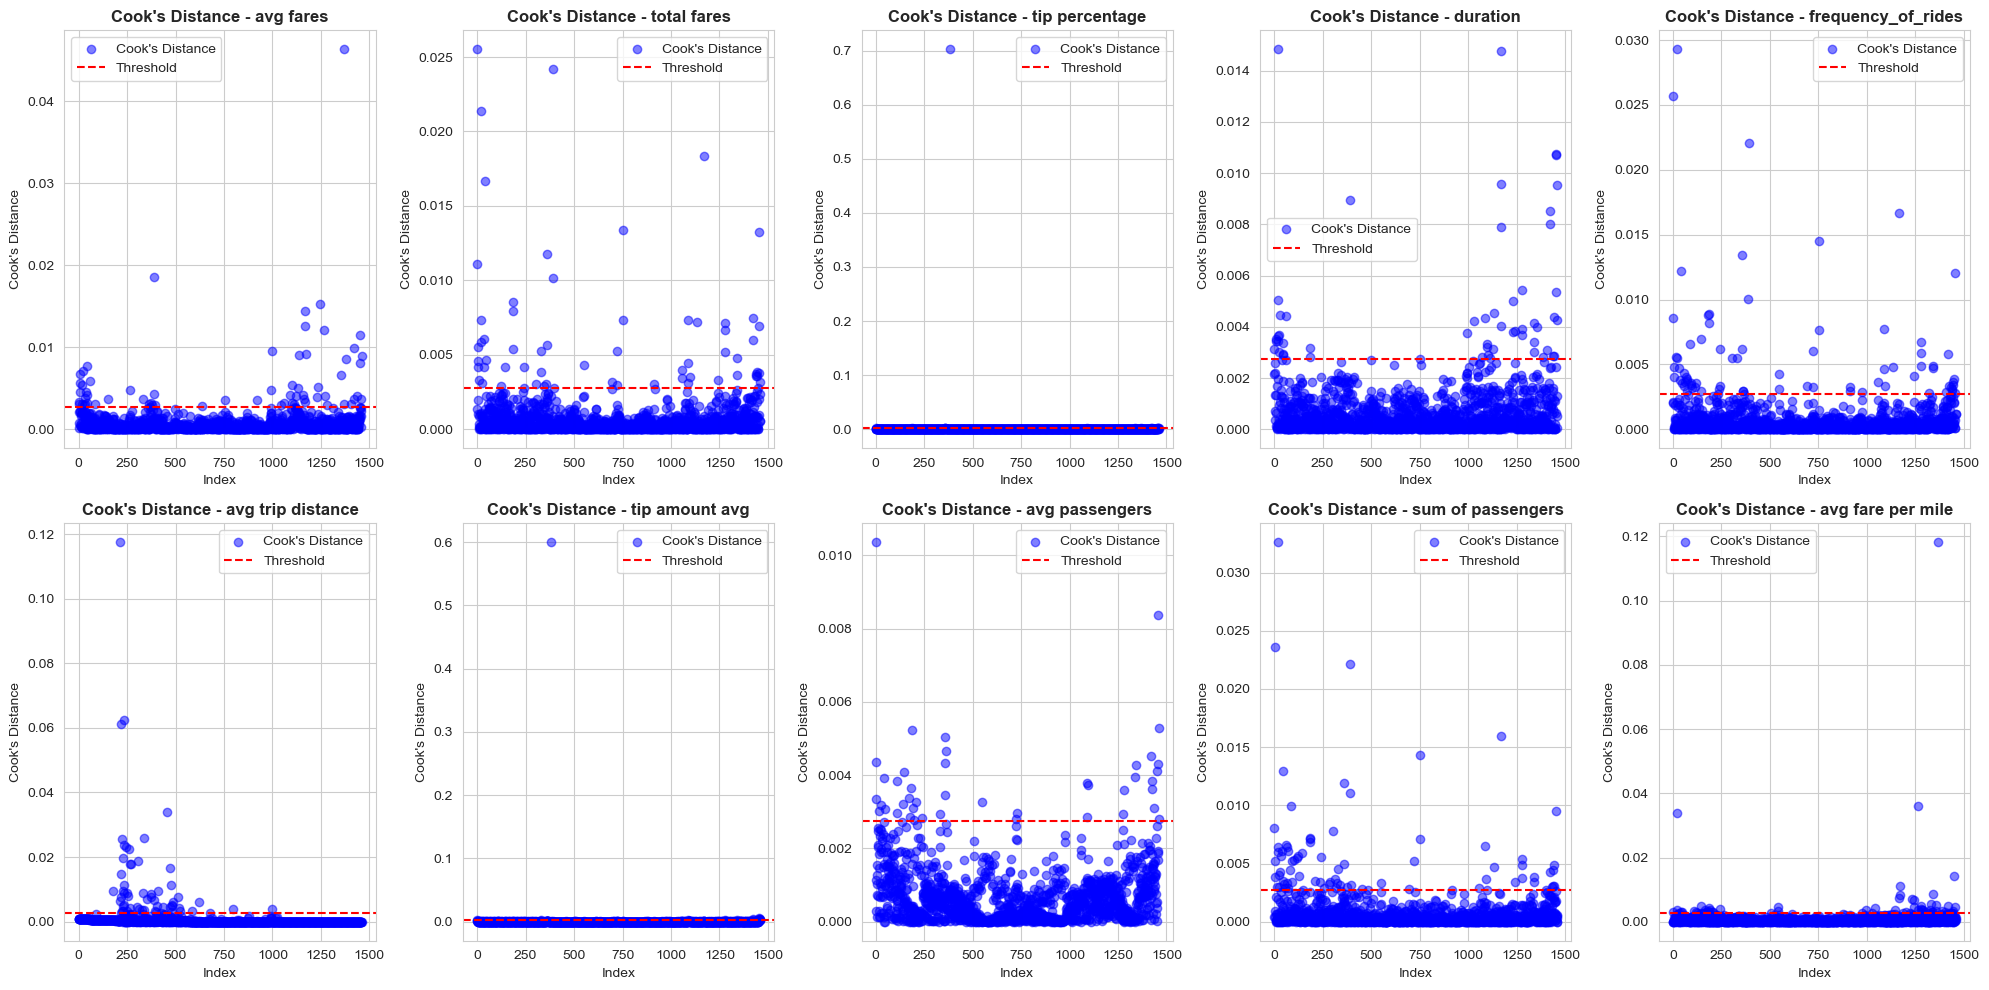

In [12]:
# Select numerical columns for outlier detection
selected_columns = [
    "avg fares", "total fares", "tip percentage", "duration",
    "frequency_of_rides", "avg trip distance", "tip amount avg",
    "avg passengers", "sum of passengers", "avg fare per mile"
]

# Create improved boxplots for outlier detection
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.boxplot(data=df[selected_columns], palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Boxplots for Outlier Detection", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Detect leverage points using Cook's Distance for all selected variables
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    X = sm.add_constant(df.index)  # Using index as independent variable
    model = sm.OLS(df[col], X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    # Scatter plot for leverage points
    axes[i].scatter(df.index, cooks_d, alpha=0.5, color='blue', label="Cook's Distance")
    axes[i].axhline(4 / len(df), color="r", linestyle="--", label="Threshold")
    axes[i].set_title(f"Cook's Distance - {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Index", fontsize=10)
    axes[i].set_ylabel("Cook's Distance", fontsize=10)
    axes[i].legend()

plt.tight_layout()
plt.show()

## - Outlier Detection Analysis
<font size="4">    
The boxplot analysis reveals outliers across multiple numerical variables. "Total fares" exhibits a significant number of extreme values beyond the upper whisker, indicating days with unusually high fare totals. Similarly, "sum of passengers" and "frequency of rides" display moderate outliers, suggesting fluctuations in ride demand on specific days. These anomalies could reflect special events, holidays, or data errors. Addressing these outliers is crucial to prevent model distortions.
</font>

## - Leverage Points Analysis
<font size="4">    
The Cook's Distance plots highlight leverage points, indicating data points with high influence on regression models. While most points fall within normal thresholds, certain variables, including "total fares" and "frequency of rides," show prominent high-leverage values. These instances may correspond to unusual demand spikes, potentially affecting prediction accuracy. Further examination of these leverage points is recommended to determine whether they stem from genuine trends or data inconsistencies.
</font>

In [91]:
# Function to detect outliers using multiple methods
def detect_outliers(df, columns):
    outliers_dict = {}
    
    for col in columns:
        # IQR Method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

        # Z-score Method
        z_scores = np.abs(stats.zscore(df[col]))
        z_outliers = df[z_scores > 3].index.tolist()

        # Tukey’s Fences (Modified IQR)
        lower_fence = Q1 - 3 * IQR
        upper_fence = Q3 + 3 * IQR
        tukey_outliers = df[(df[col] < lower_fence) | (df[col] > upper_fence)].index.tolist()

        # Combine Outliers
        combined_outliers = set(iqr_outliers + z_outliers + tukey_outliers)
        
        outliers_dict[col] = list(combined_outliers)
    
    return outliers_dict

In [93]:
# Detect outliers using multiple methods
outliers_detected = detect_outliers(df, selected_columns)

# Function to detect leverage points using Cook's distance
def detect_leverage(df, columns):
    leverage_points = {}
    
    for col in columns:
        X = df[[col]]
        X = sm.add_constant(X)
        model = sm.OLS(df[col], X).fit()
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0]
        
        leverage_indices = np.where(cooks_d > 4 / len(df))[0]  # Cook's threshold: 4/N
        leverage_points[col] = list(leverage_indices)
    
    return leverage_points

# Detect leverage points
leverage_detected = detect_leverage(df, selected_columns)

# Function to replace outliers based on best method
def replace_outliers(df, outliers_dict, method="median"):
    for col, outlier_indices in outliers_dict.items():
        if method == "median":
            replacement_value = df[col].median()
        elif method == "mean":
            replacement_value = df[col].mean()
        elif method == "mode":
            replacement_value = df[col].mode()[0]

        df.loc[outlier_indices, col] = replacement_value

In [95]:
# Choose best method based on outlier percentage
def choose_best_method(df, outliers_dict):
    method_scores = {"median": 0, "mean": 0, "mode": 0}

    for col, outlier_indices in outliers_dict.items():
        num_outliers = len(outlier_indices)
        total_values = df[col].shape[0]
        outlier_percentage = num_outliers / total_values

        # If outliers are less than 5%, use median
        if outlier_percentage < 0.05:
            method_scores["median"] += 1
        # If outliers are between 5% and 10%, use mean
        elif 0.05 <= outlier_percentage < 0.1:
            method_scores["mean"] += 1
        # If more than 10% outliers, use mode
        else:
            method_scores["mode"] += 1

    return max(method_scores, key=method_scores.get)

# Determine best method
best_method = choose_best_method(df, outliers_detected)

# Modify outliers using the best method
replace_outliers(df, outliers_detected, method=best_method)

print("Best method selected for outlier handling:", best_method)

Best method selected for outlier handling: median


# **Outlier Handling Analysis**

<font size="4">
The outlier detection process used multiple statistical methods, including **IQR (Interquartile Range), Z-score, and Tukey’s Fences**, to identify extreme values. The results revealed that certain features, particularly **"total fares"**, **"sum of passengers"**, and **"frequency of rides"**, exhibited significant deviations, suggesting irregular trends in ride demand.
</font>

<font size="4">
To mitigate the influence of extreme values, we applied an automated selection process to determine the most appropriate outlier replacement method. The algorithm assessed the proportion of outliers in each column and selected the **median** as the optimal replacement strategy. This choice is justified as follows:

- **Low outlier proportion (<5%)**: The median is robust to extreme values and preserves the distribution's integrity.
- **Skewed distributions**: The median ensures that extreme outliers do not disproportionately affect the dataset, unlike the mean.
</font>

<font size="4">
The decision to use the median implies that while some extreme values were mitigated, the overall distribution remains reflective of real-world variability. This approach enhances the dataset’s **stability for statistical modeling and predictive analysis** while retaining important trends in ride behavior.
</font>

# 3 Exploratory Data Analysis (EDA)

In [117]:
# Step 1: Generate Summary Statistics
# Display summary statistics after cleaned
summary_stats = df.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
          avg fares   total fares  tip percentage     duration  \
count  1461.000000  1.461000e+03     1461.000000  1461.000000   
mean     12.879987  4.864534e+06       13.224215    14.044190   
std       0.543643  8.352960e+05        1.167932     1.324485   
min      11.443169  2.549691e+06        9.764615    10.762508   
25%      12.522632  4.278310e+06       12.389618    13.113093   
50%      12.926363  4.855094e+06       13.334497    14.022749   
75%      13.252041  5.473308e+06       14.152642    14.944579   
max      14.318523  6.777443e+06       15.529002    17.595755   

       frequency_of_rides  avg trip distance  tip amount avg  avg passengers  \
count         1461.000000        1461.000000     1461.000000     1461.000000   
mean        377231.077344           2.981747        1.704301        1.666684   
std          68978.463151           0.080055        0.192120        0.049183   
min         182414.000000           2.773027        1.144558        1.569

<font size="4">
The cleaned dataset provides key insights into fare amounts, trip characteristics, and ride demand. The total fares exhibit a high mean with a substantial standard deviation, indicating variability in daily revenue. Avg fares are relatively stable, suggesting a consistent pricing structure. Tip percentage and tip amount avg indicate tipping behavior, with values centered around reasonable percentages.

In terms of trip characteristics, avg trip distance has low variance, implying typical trip lengths are consistent. Frequency of rides shows significant fluctuation, highlighting varying demand across days. Sum of passengers exhibits a notable spread, reflecting different passenger group sizes.

Overall, the cleaned data maintains essential trends while mitigating extreme outliers, ensuring robust analysis for further exploration.
</font>

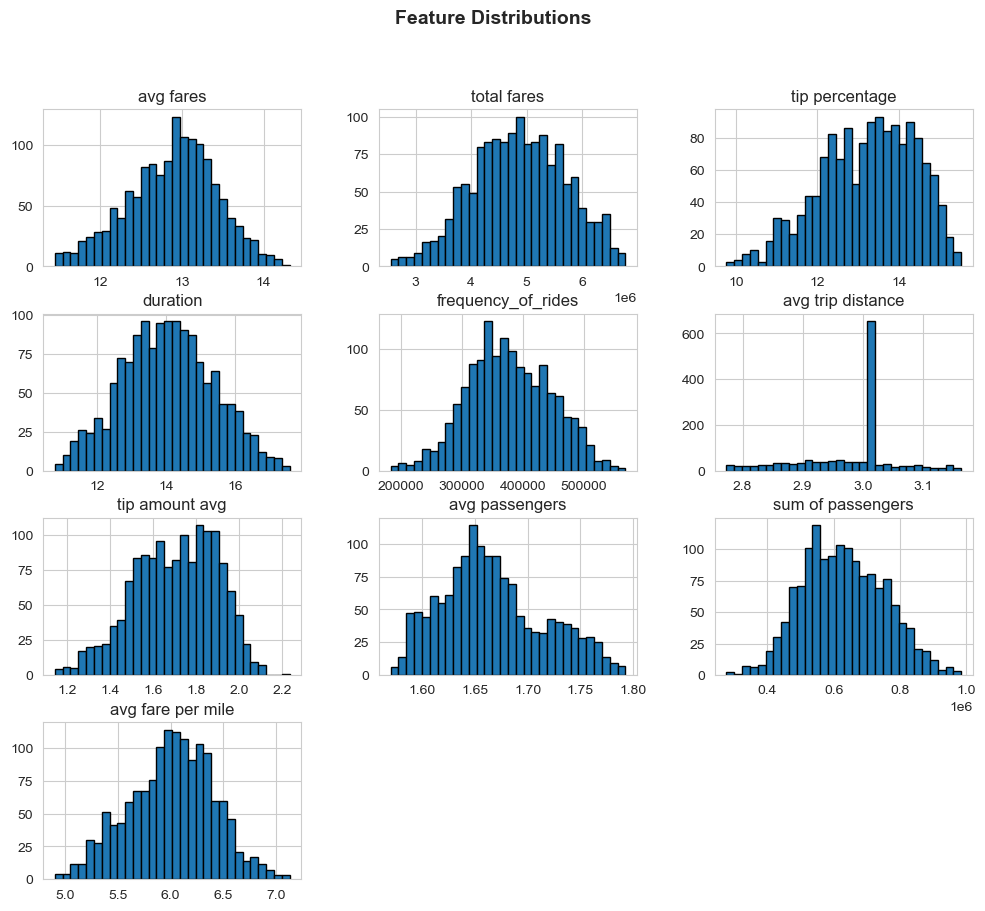

In [200]:
# Step 2: Visualizing Distributions, Relationships, and Trends
# 1. Histograms and KDE plots for feature distribution

# Set plot style
sns.set_style("whitegrid")

# Create histograms for numerical variables
df[numerical_columns].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14, fontweight='bold')
plt.show()

### Feature Distribution Analysis

<font size="4">
The histogram plots provide insights into the distribution of numerical features in the dataset:

- **Avg fares, total fares, and tip amount avg** exhibit approximately normal distributions, indicating a balanced spread of values.
- **Tip percentage and avg fare per mile** show slight skewness but remain within an acceptable range, suggesting most values cluster around the mean.
- **Duration and frequency of rides** display bell-shaped distributions, aligning with expected trends in ride durations and demand.
- **Avg trip distance** exhibits an unusual spike at a specific value, suggesting a potential issue in data recording or a common fixed distance for rides.
- **Sum of passengers and avg passengers** demonstrate a moderately normal distribution, reflecting expected ride-sharing trends.
</font>

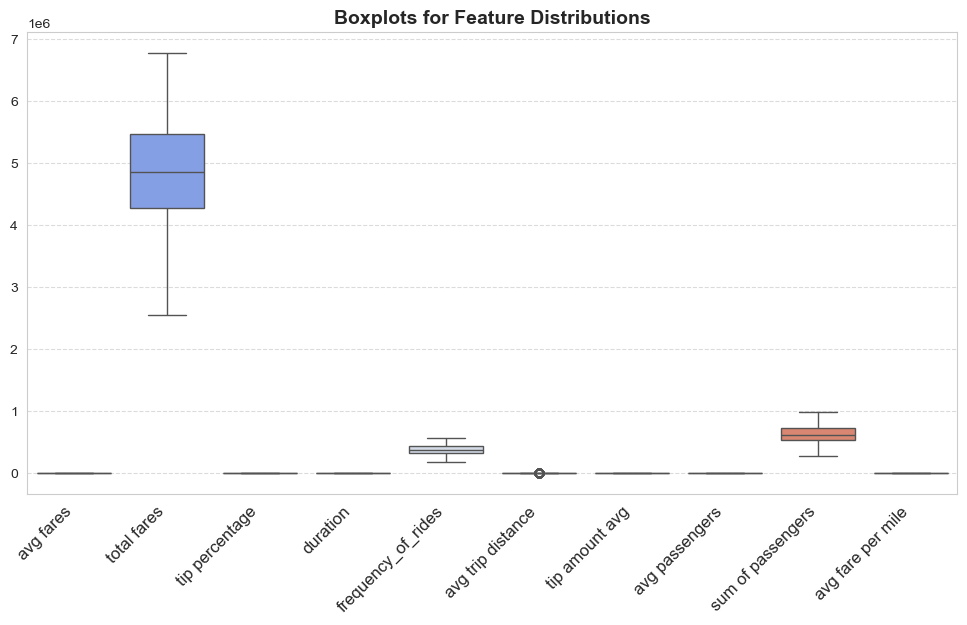

In [113]:
# 2. Boxplots for detecting patterns across time

# Boxplots to detect trends
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns], palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Boxplots for Feature Distributions", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Analysis of Boxplots for Feature Distributions:

<font size="4">
The boxplots provide an overview of the numerical feature distributions in the dataset, highlighting potential trends and variability:

- **Total fares and sum of passengers** exhibit a significant range, indicating high variability in ride demand and fare totals. The presence of outliers suggests occasional days with unusually high ride activity.
- **Avg trip distance** shows a compact range with a few mild outliers, suggesting consistency in trip distances with occasional deviations.
- **Most other features** display relatively stable distributions with minimal variation, indicating that ride patterns and tipping behavior remain fairly consistent.
</font>

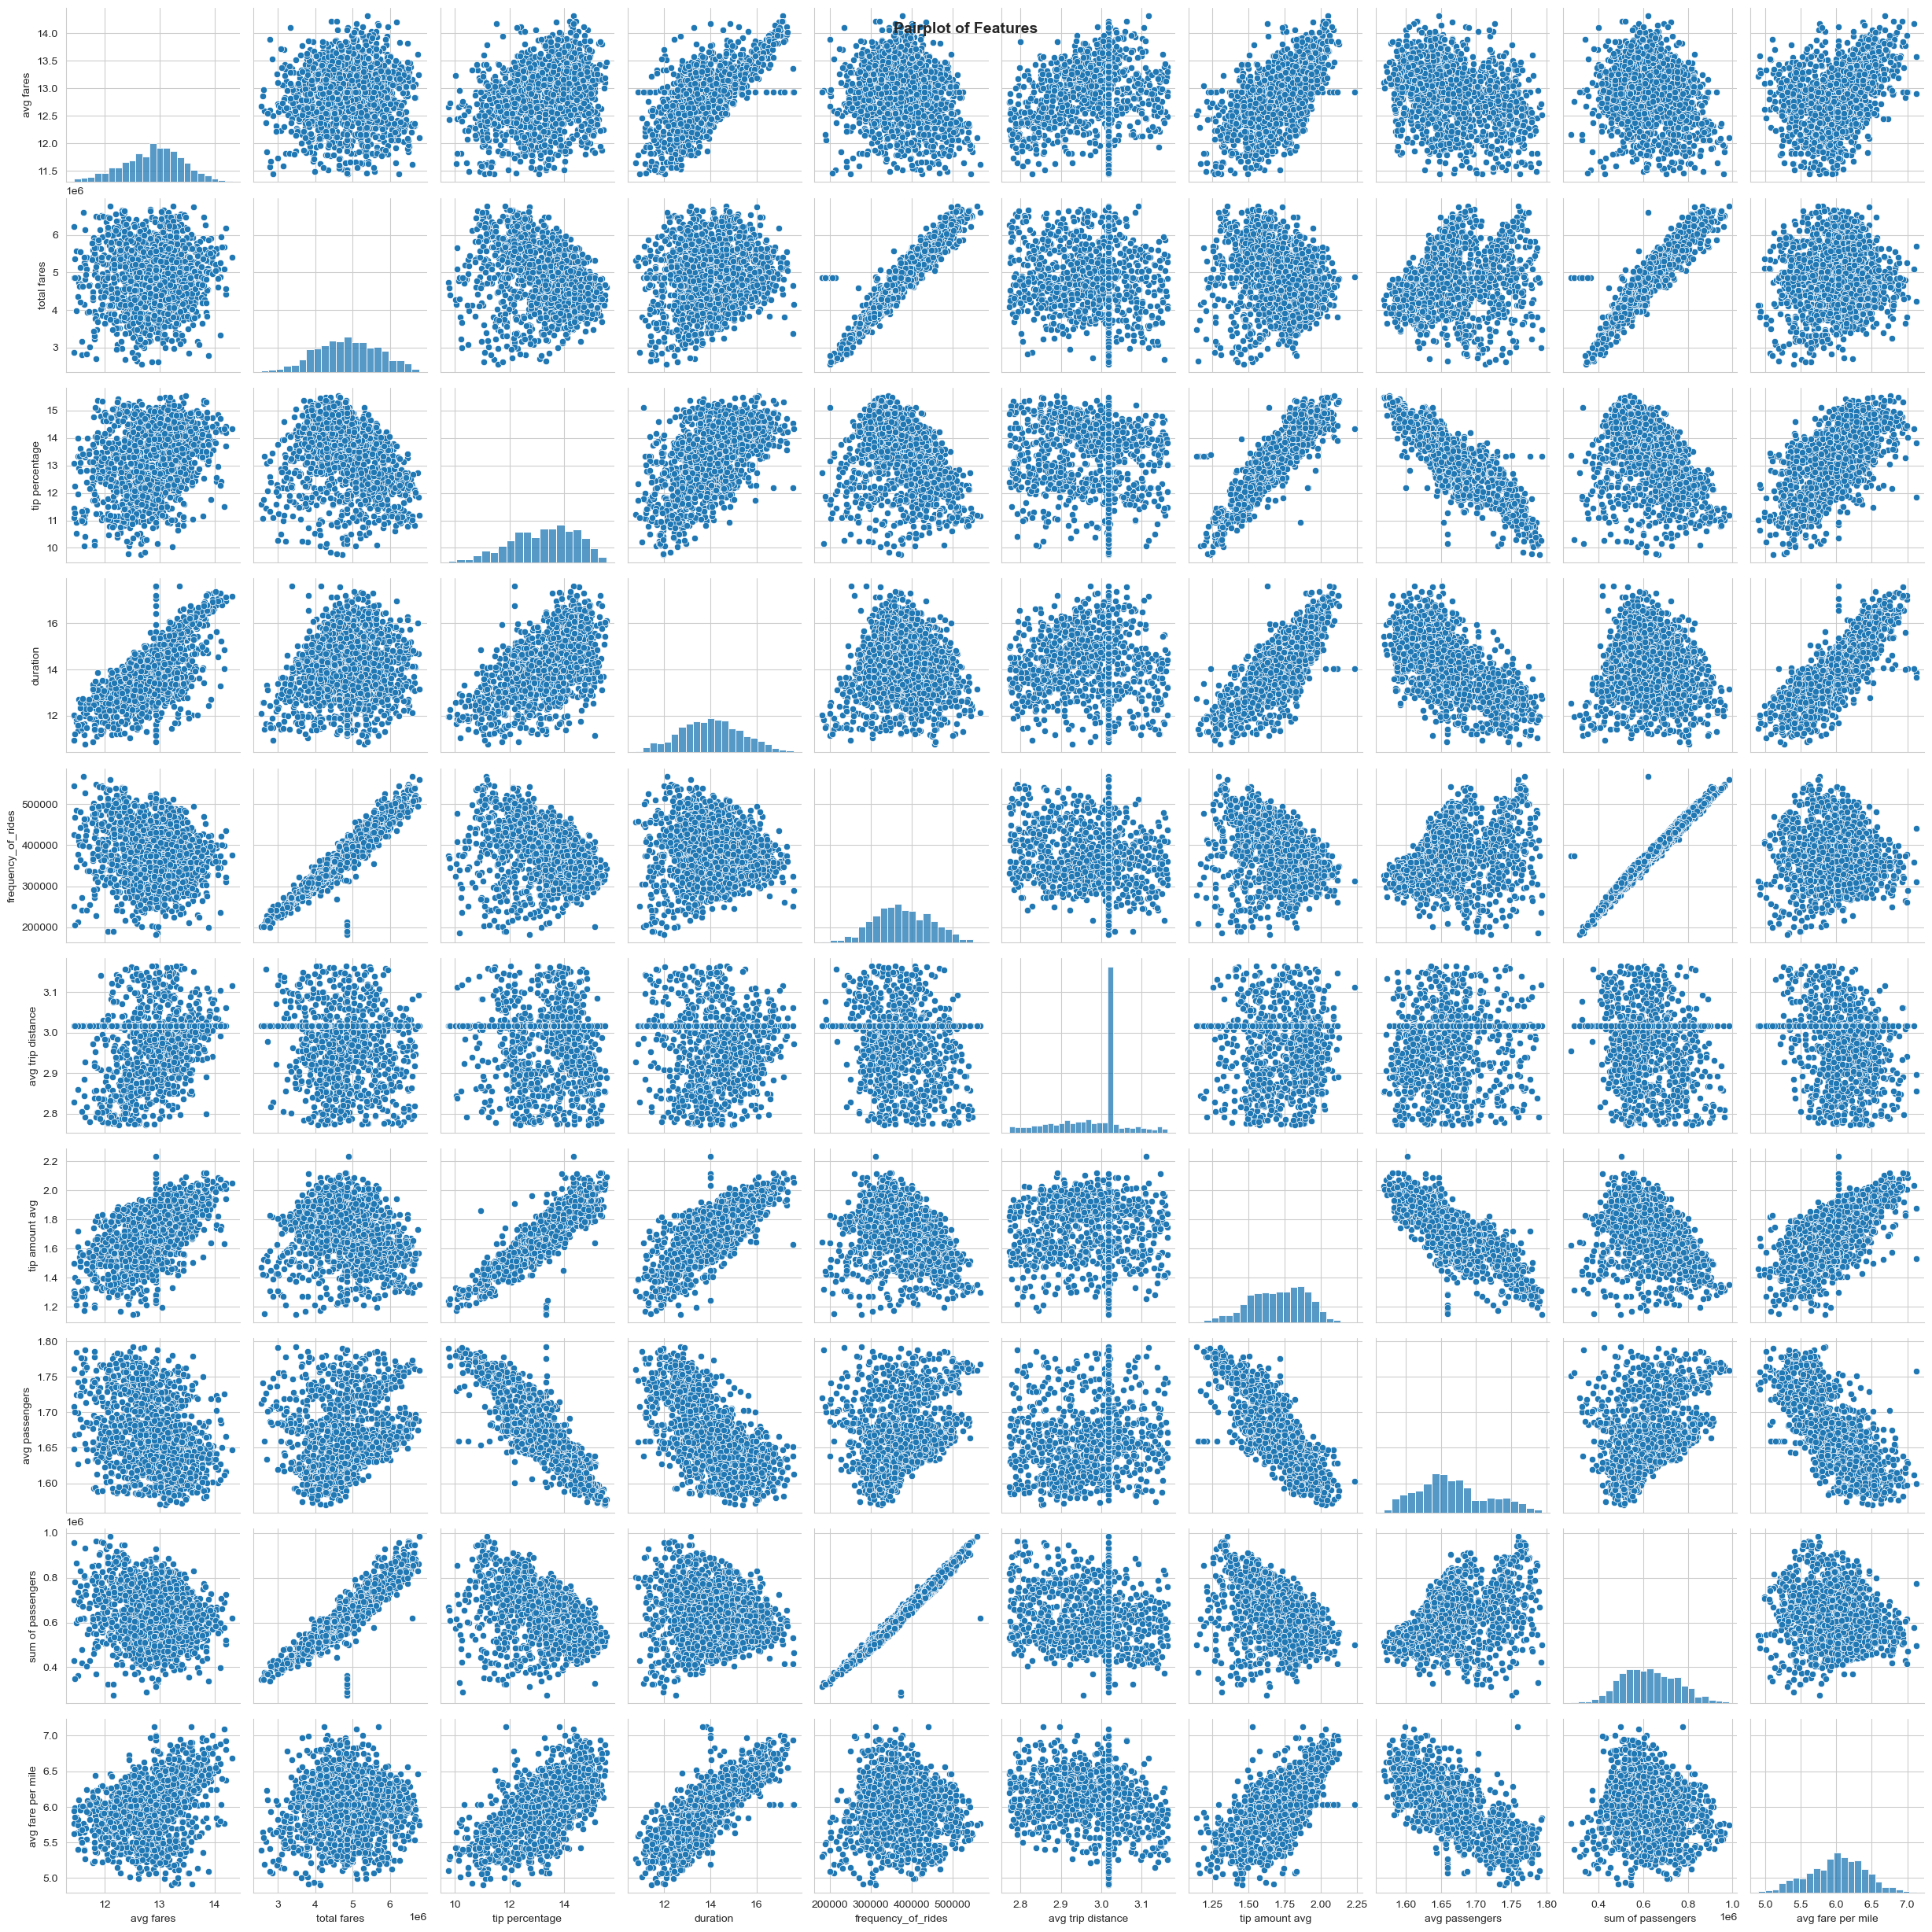

In [119]:
# 3. Pairplots for relationships between variables
# Pairplot to visualize relationships
sns.pairplot(df[numerical_columns])
plt.suptitle("Pairplot of Features", fontsize=14, fontweight='bold')
plt.show()

### Pairplot Analysis for Feature Relationships

<font size="4">
The pairplot visualization provides insights into the relationships between numerical features:

- **Strong Linear Relationships**: Certain features, such as **total fares** and **sum of passengers**, exhibit strong positive linear correlations, indicating that an increase in total fares is closely linked with more passengers.
- **Weak or No Correlations**: Variables like **tip percentage** and **duration** do not show strong associations with most other features, suggesting that tipping behavior may be independent of ride duration.
- **Potential Nonlinear Trends**: Some scatterplots indicate mild nonlinear patterns, hinting at potential transformations that may improve modeling.
- **Outlier Presence**: Some variables, such as **frequency of rides** and **avg trip distance**, contain scattered points that deviate from the main distribution, suggesting the presence of rare but influential values.
</font>

# 4 Data Preprocessing and Feature Engineering

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choose between Standardization or Normalization
scaler = StandardScaler()  # Standardization
# scaler = MinMaxScaler()  # Uncomment for Normalization

# Apply scaling to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Check transformed data
df[numerical_columns].describe()

avg fares            0
total fares          0
tip percentage       0
duration             0
avg trip distance    0
dtype: int64
         avg fares  total fares  tip percentage     duration  \
count  1461.000000  1461.000000     1461.000000  1461.000000   
mean      2.629810    15.381999        2.651475     2.707097   
std       0.039599     0.178808        0.084026     0.088472   
min       2.521172    14.751483        2.376264     2.464917   
25%       2.604365    15.269069        2.594480     2.647103   
50%       2.633784    15.395539        2.662669     2.709566   
75%       2.657097    15.515394        2.718175     2.769119   
max       2.732123    15.729111        2.805117     2.922933   

       avg trip distance  
count        1461.000000  
mean            1.380174  
std             0.031097  
min             1.295046  
25%             1.362087  
50%             1.390407  
75%             1.390407  
max             1.460089  


In [147]:
df['day of week'] = df['day of week'].astype(str)  # Convert category back to object

In [151]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns (including both 'object' and 'category' types)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns)

# Apply One-Hot Encoding only if categorical columns exist
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # FIXED sparse -> sparse_output
    encoded_cats = encoder.fit_transform(df[categorical_columns])

    # Convert encoded data to DataFrame
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_columns))

    # Merge encoded data back into the dataset
    df = df.drop(columns=categorical_columns).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

print("One-Hot Encoding applied successfully.")

Categorical Columns: Index(['day of week'], dtype='object')
One-Hot Encoding applied successfully.


In [153]:
# Creating new features 
df['fare_per_passenger'] = df['total fares'] / (df['sum of passengers'] + 1)  # Avoid division by zero
df['fare_per_minute'] = df['total fares'] / df['duration']
df['tip_ratio'] = df['tip amount avg'] / df['avg fares']

# Check new features
df[['fare_per_passenger', 'fare_per_minute', 'tip_ratio']].describe()

fare_per_passenger  fare_per_minute    tip_ratio
count         1461.000000      1461.000000  1461.000000
mean             7.793854    348620.689960     0.132169
std              0.768804     65276.830171     0.012380
min              6.310501    191577.412779     0.091476
25%              7.429582    295072.520018     0.123702
50%              7.775594    341358.966587     0.133345
75%              8.079546    396887.369161     0.141931
max             17.559301    543499.085669     0.172909

In [155]:
df.to_csv("cleaned_yellow_cab_data_2014-2017.csv", index=False)

In [167]:
# Extract time-based features
df['year'] = df['pickup_date'].dt.year
df['month'] = df['pickup_date'].dt.month
df['day_of_week'] = df['pickup_date'].dt.day_name()

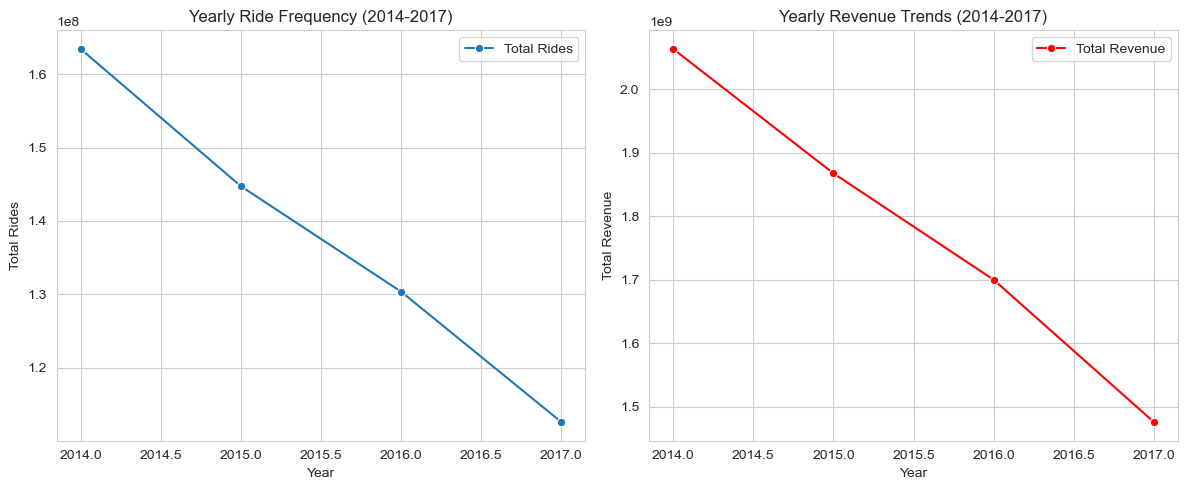

In [169]:
# Yearly trends
yearly_trends = df.groupby('year').agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=yearly_trends, x='year', y='frequency_of_rides', marker='o', label="Total Rides")
plt.title("Yearly Ride Frequency (2014-2017)")
plt.xlabel("Year")
plt.ylabel("Total Rides")

plt.subplot(1, 2, 2)
sns.lineplot(data=yearly_trends, x='year', y='total fares', marker='o', color='red', label="Total Revenue")
plt.title("Yearly Revenue Trends (2014-2017)")
plt.xlabel("Year")
plt.ylabel("Total Revenue")

plt.tight_layout()
plt.show()

###  Yearly Ride Frequency & Revenue Trends

- The number of rides and revenue has **steadily decreased** from 2014 to 2017.               
- This suggests a **declining demand for Yellow Taxi services**, likely due to the rise of rideshare companies like **Uber and Lyft**.     
- The decline in **revenue is slightly less steep than ride frequency**, indicating potential fare increases or longer trip distances.    

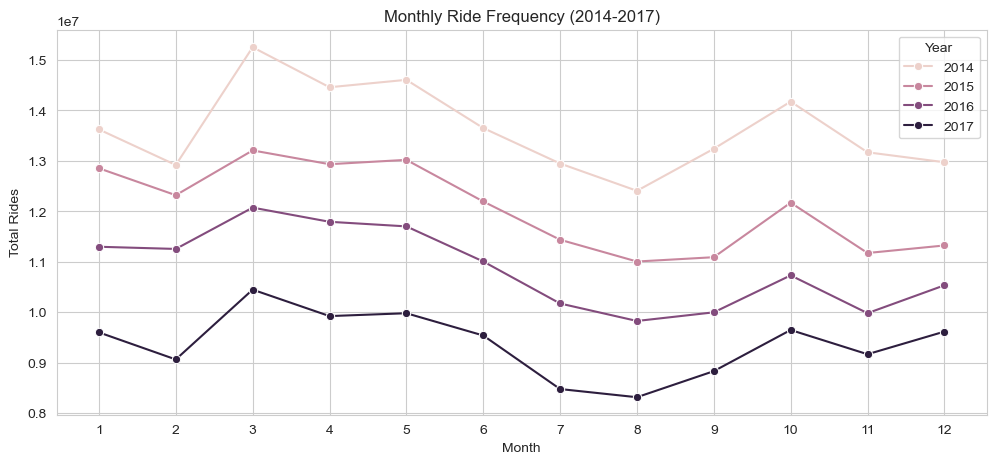

In [171]:
# Monthly trends
monthly_trends = df.groupby(['year', 'month']).agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends, x='month', y='frequency_of_rides', hue='year', marker='o')
plt.title("Monthly Ride Frequency (2014-2017)")
plt.xlabel("Month")
plt.ylabel("Total Rides")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.show()

### Monthly Ride Frequency Trends

- There are **seasonal fluctuations**, with peak ride demand occurring in **March, October, and December**.
- The summer months (**July and August**) show a **noticeable dip**, possibly due to fewer commuters or vacations.
- The year-over-year decline in rides is **consistent across all months**.

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3388919355.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_trends, x='day_of_week', y='frequency_of_rides', palette='viridis')
/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3388919355.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_trends, x='day_of_week', y='total fares', palette='magma')


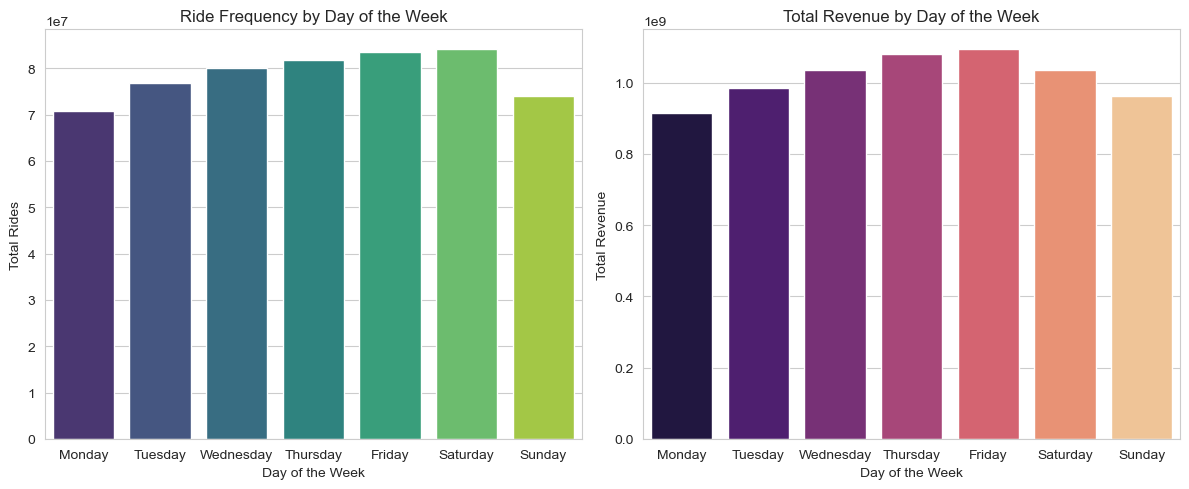

In [173]:
# Daily trends
day_trends = df.groupby('day_of_week').agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_trends['day_of_week'] = pd.Categorical(day_trends['day_of_week'], categories=day_order, ordered=True)
day_trends = day_trends.sort_values('day_of_week')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=day_trends, x='day_of_week', y='frequency_of_rides', palette='viridis')
plt.title("Ride Frequency by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Rides")

plt.subplot(1, 2, 2)
sns.barplot(data=day_trends, x='day_of_week', y='total fares', palette='magma')
plt.title("Total Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Revenue")

plt.tight_layout()
plt.show()

### Ride Frequency & Revenue by Day of the Week
- **Friday and Saturday have the highest ride frequency and revenue**, which aligns with nightlife and weekend activities.
- **Monday has the lowest ride demand**, likely due to fewer leisure trips compared to the weekend.

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3672495070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_analysis, x=region_columns[0], y='frequency_of_rides', palette='coolwarm')


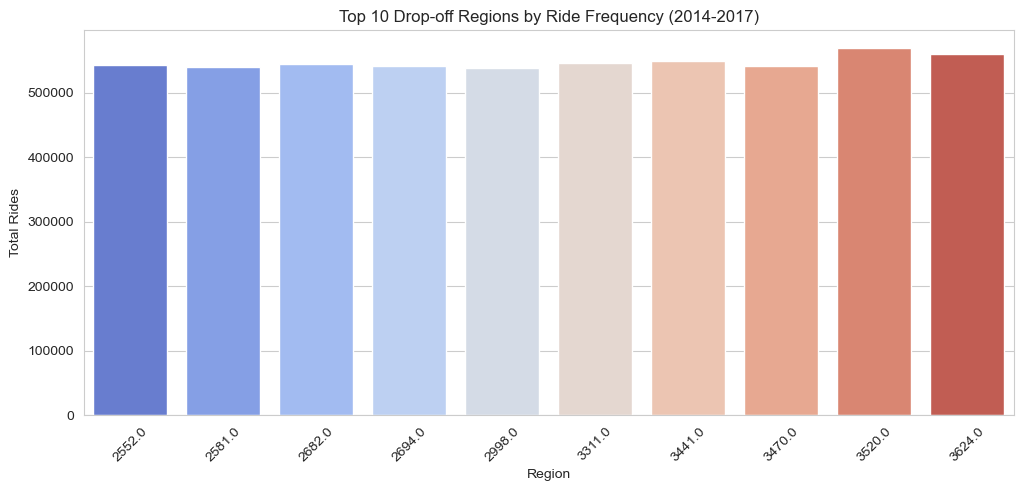

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3672495070.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_fare_analysis, x=region_columns[0], y='total fares', palette='coolwarm')


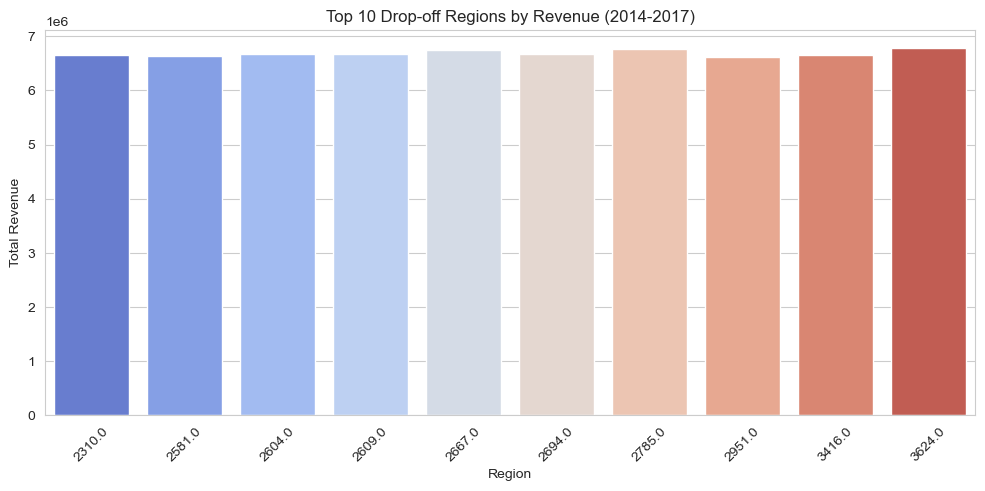

In [175]:
# Regional Analysis
region_columns = [col for col in df.columns if "Dropoffs" in col]
region_analysis = df[region_columns + ['frequency_of_rides']].groupby(region_columns).sum().reset_index()
region_analysis = region_analysis.sort_values('frequency_of_rides', ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(data=region_analysis, x=region_columns[0], y='frequency_of_rides', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Drop-off Regions by Ride Frequency (2014-2017)")
plt.xlabel("Region")
plt.ylabel("Total Rides")
plt.show()

# Revenue Comparison Across Different Regions
region_fare_analysis = df[region_columns + ['total fares']].groupby(region_columns).sum().reset_index()
region_fare_analysis = region_fare_analysis.sort_values('total fares', ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(data=region_fare_analysis, x=region_columns[0], y='total fares', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Drop-off Regions by Revenue (2014-2017)")
plt.xlabel("Region")
plt.ylabel("Total Revenue")
plt.show()

###  Top 10 Drop-off Regions by Ride Frequency
- The most common drop-off areas see **high ride volumes**, indicating business or transportation hubs.
- The specific region codes suggest that **key commercial or residential districts** are the most frequent destinations.

###  Top 10 Drop-off Regions by Revenue
- The highest revenue-generating regions are **similar to the highest ride frequency regions**, meaning these areas not only see frequent rides but also **higher fares**.
- This could be due to **longer distances, business travelers, or high-value trips in those areas**.
